# INTRODUCTION

In this project, we take the most famous attractions in Disney Magic Kingdom - Seven Dwarfs Mine Train as an example to simulate the waiting time over the time of day. The duration of this ride is 2 minutes and 50 seconds with eatimated 43 seconds minimum and 67 seconds maximum loading time [https://touringplans.com/blog/seven-dwarfs-mine-train-opening-day-observations/]. There are 5 trains in total. Each train has 5 cars and each car can take 20 riders.


# LOAD LIBRARIES

In [156]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
import time
import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# CUSTOMER ARRIVAL - PIOSSON PROCESS

We simulate customer arrival as a nonhomogeneous Poisson process with time-dependent rate parameter $λ(t)$. Generating nonhomogeneous Poisson process is less intuitive as comparing to homogeneous Poisson process. Lewis proposed a method which is a “process analogue” of acceptance-rejection named thinning. First, find a constant rate $λ^* \ge λ(t)$, next generate from the homogeneous Poisson process with $λ^*$, and then reject an appropriate fraction of the generated events so that the desired rate $λ(t)$ is achieved. the algorithm contains following steps:
1. Generate points from homogeneous Poisson process with rate function $λ^*$. 
2. Denote the generated points by $X^*_1, X^*_2, \cdots, X^*_n$. Initialize $i = 1, k = 0$, repeat steps 3 until i reaches n.
3. Generate $u_i\sim U(0, 1)$, if $u_i \le \frac{λ(X^*_i)}{λ^*}$, then accept and deliver $X^*_i$.

Note that the way of simulating the homogeneous Poisson process is to use the property that the time intervals between two successive events follow an exponential distribution. Poisson process are obtained by cumulatively summing all of time intervals.


In [158]:
class PoissonProcess():
    def __init__(self, lam, T):
        self.lam = lam
        self.T = T
        self.simulate()

    def simulate(self):
        N = int(self.lam * self.T)
        inter_ls = np.random.exponential(1/self.lam, size=N)  ## simulate using exponential distribution
        arrival_time_ls = np.cumsum(inter_ls)
        self.arrival_time_ls = arrival_time_ls[arrival_time_ls <= self.T]

    def get_arrival_time(self):
        return self.arrival_time_ls

In [159]:
def arrivalrate_function(t):
  y = (-1.8*t**4 + 40.5*t**3 - 390*t**2 + 1575*t + 890)
  return y

def generate_customer_arrivals():
  ## thining function to simulate non-homogeneuous Poisson process
  optimized = minimize(lambda t: -arrivalrate_function(t), 0, tol=1e-9)
  Max_ArrRate = -optimized.fun

  ## Original Arrival List (simulated with the maximum rate)  
  original_process = PoissonProcess(lam = Max_ArrRate, T = 11.999)
  original_arrival_ls = original_process.get_arrival_time()
  num_original_arrivals = len(original_arrival_ls)

  ## Thinning Process
  accepted_arrival_ls = [] 
  for arr_time in original_arrival_ls:
    u = np.random.uniform(0,1)
    keep_prob = np.round(arrivalrate_function(arr_time),3) / round(Max_ArrRate,3)        
    if u <= keep_prob:
        accepted_arrival_ls = np.append(accepted_arrival_ls, np.round(arr_time,3))
  return accepted_arrival_ls

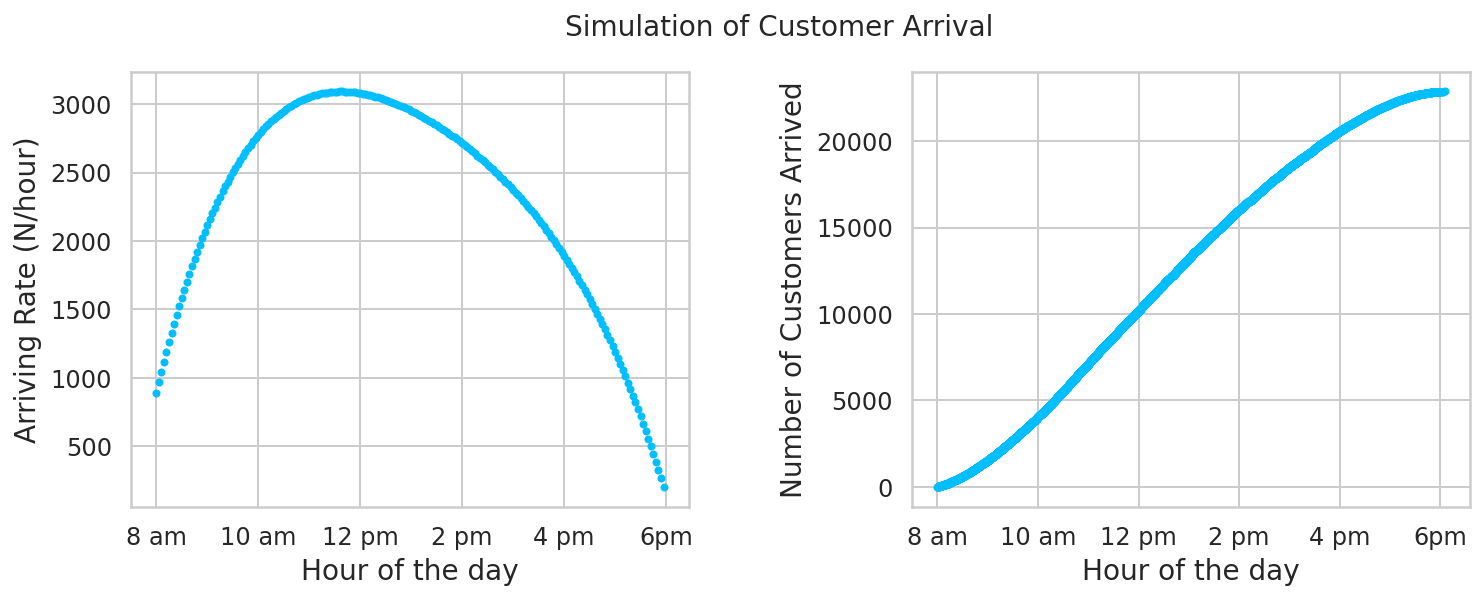

In [160]:
##  In 2022, attendance has averaged so far at 57,000 visitors per day.
fig = plt.figure(figsize=(12, 4))
plt.suptitle('Simulation of Customer Arrival', fontsize = 14)

plt.subplot(121)
x = np.arange(start = 0, stop = 10, step = 0.05)
y = arrivalrate_function(x)
t = x + 8
plt.plot(t, y, '.')
plt.xticks(np.arange(8, 19, 2), ['8 am', '10 am', '12 pm', '2 pm', '4 pm', '6pm'], fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Hour of the day', fontsize = 14)
plt.ylabel('Arriving Rate (N/hour)', fontsize = 14)

plt.subplot(122)
accepted_arrival_ls = generate_customer_arrivals()
n = np.arange(start = 0, stop = len(accepted_arrival_ls), step = 1)
hours = accepted_arrival_ls + 8
plt.plot(hours, n, '.')
plt.xticks(np.arange(8, 19, 2), ['8 am', '10 am', '12 pm', '2 pm', '4 pm', '6pm'], fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Hour of the day', fontsize = 14)
plt.ylabel('Number of Customers Arrived', fontsize = 14)

plt.subplots_adjust(hspace = 0, wspace = 0.4)

In [173]:
len(accepted_arrival_ls)

22873

# CUSTOMER DROPOUT

The probability of customer dropout follows a stepwise function of waiting time. The longer the waiting time is, the more likely for a customer to dropout from current queue.

In [161]:
def abandon_prob(prev_cust_wait):        
    if prev_cust_wait < 30:
        abandon_prob = 0
    elif prev_cust_wait>= 30 and prev_cust_wait< 50:
        abandon_prob = 0.01
    elif prev_cust_wait>= 50 and prev_cust_wait< 75:
        abandon_prob = 0.05
    elif prev_cust_wait>=75 and prev_cust_wait< 120:
        abandon_prob = 0.1
    elif prev_cust_wait>=120:
        abandon_prob = 0.15
        
    return abandon_prob

Text(0, 0.5, 'Dropout Probability')

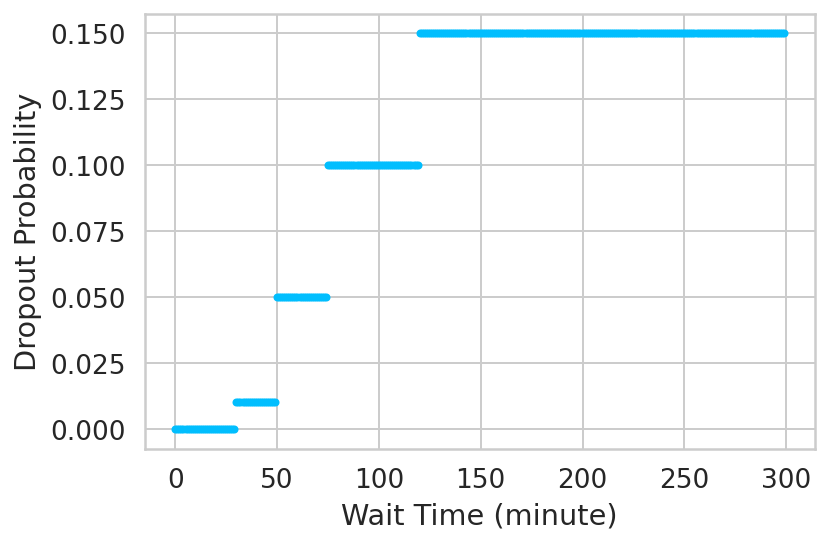

In [162]:
T = np.arange(start = 0, stop = 300, step = 1)  
p = [abandon_prob(t) for t in T]
plt.plot(T, p, '.')
plt.xlabel('Wait Time (minute)')
plt.ylabel('Dropout Probability')

# SERVICE TIME

We assume that loading time and unloading time follow uniform distribution while the riding time is a constant.

In [163]:
def service_time():
  load_min, load_max = 43/60, 67/60
  unload_min, unload_max = 0.2, 0.4
  
  load_time =  np.random.uniform(load_min, load_max)
  unload_time = np.random.uniform(unload_min, unload_max)
  riding_time = 2+50/60
  service_time = load_time + riding_time + unload_time

  return service_time

# CUSTOMERS

We define two classes:
- Customer class: stores each customer's arrival time and waiting time. Initialize waiting time as 0.
- Customer_ls class: representing the waiting queue. It contains functions of customer exit and new customer joining.

In [164]:
class Customer():
    def __init__(self, arrival_time=0, ctype='normal',wait_time=0):
        self.arrival_time = arrival_time
        self.ctype = ctype
        self.wait_time = wait_time

In [165]:
class Customer_ls():
    empty = ()

    def __init__(self, customer_ls=np.array([])):
        self.customer_ls = np.array(customer_ls)
        self.customer_ls = self.customer_ls[np.argsort([customer.arrival_time for customer in customer_ls])]
        self.next = None if not customer_ls else self.customer_ls[0]

    def __len__(self):
        return len(self.customer_ls)
        
    def next_exits(self):
        if len(self)==1:
            next_cust, self.customer_ls = self.customer_ls[0], np.array([])
            self.next = None
        else:
            next_cust, self.customer_ls = self.customer_ls[0], self.customer_ls[1:]
            self.next = self.customer_ls[0]
        return next_cust
    
    def add_to_nosort(self, customer):
        self.customer_ls = np.append(self.customer_ls, customer)
        self.next = self.customer_ls[0]

# SIMULATION

When a customer arrives, there are three scenarios:
1. For the first train of the day, the train won't leave until enough people arrived.
2. When a customer arrives and trains are still running, customer joins the waiting queue.
3. If there are enough people and no train is running, send a train.

In [166]:
def sim_waiting_time(capacity11am = 100, capactity2pm = 100):
  accepted_arrival_ls = generate_customer_arrivals()
  # convert to minutes
  customer_arrivals = [Customer(arr*60) for arr in accepted_arrival_ls]
  customer_arrivals = Customer_ls(customer_arrivals)
  NormalQueue, CustExit = Customer_ls(), Customer_ls()

  CAPACITY = 100
  train_finish_time, prev_wait_time = 0, 0
  while len(customer_arrivals) > 0 or len(NormalQueue) > 0:
    next_arr = customer_arrivals.next
    
    ## Scenario 1: FIRST CAR DOESN"T LEAVE TILL FULL
    if train_finish_time == 0 and len(NormalQueue) < CAPACITY:
        next_arrival = customer_arrivals.next_exits()
        NormalQueue.add_to_nosort(next_arrival)
        if len(NormalQueue) == CAPACITY:
            train_finish_time = NormalQueue.customer_ls[-1].arrival_time #train leave time

    ## Scenario 2: New customers arrives and a train is still running
    elif len(customer_arrivals) > 0 and ( len(NormalQueue)==0 or next_arr.arrival_time < train_finish_time):
        next_arrival = customer_arrivals.next_exits()
        NormalQueue.add_to_nosort(next_arrival)

    ## Scenario 3: Send a train
    else:
        if train_finish_time > 3: 
          CAPACITY = capacity11am
        elif train_finish_time > 5:
          CAPACITY = capactity2pm

        train_max = min(CAPACITY, len(NormalQueue))

        count = 0
        while (count < train_max) & (len(NormalQueue) > 0):
          next_served = NormalQueue.next_exits() 
          prob = abandon_prob(prev_wait_time)
          
          ## NO Abandon
          if np.random.binomial(n=1, p = 1 - prob):
              # updated waiting time
              prev_wait_time = max(0, train_finish_time - next_served.arrival_time)
              next_served.wait_time = prev_wait_time

              CustExit.add_to_nosort(next_served)
              count += 1
          ## Abandon
          else:
              next_served.wait_time = -999
              CustExit.add_to_nosort(next_served)
                
        train_finish_time = train_finish_time + service_time()

  arrival0, wait0 = [], []
  for i in range(len(CustExit)):
    customer = CustExit.next_exits()
    arrival0.append(customer.arrival_time/60+8)
    wait0.append(customer.wait_time)

  data = {'arrival' : arrival0,  'wait' : wait0}
  results = pd.DataFrame(data)

  served = results.loc[results.wait != -999]
  dropped = results.loc[results.wait == -999]
  return served, dropped

def generate_plot(served, title):
  served['hour'] = served['arrival'].astype(str).str.split('.').apply(lambda x: x[0]).astype(int)
  testdf = served.groupby('hour')[['wait']].mean()

  fig2b, ax2b = plt.subplots(figsize = (8, 4.5))

  plt.plot(testdf.index, testdf['wait'], marker = 'o')
  ax2b.axhline(y = np.mean(served['wait']), c = 'g',linestyle = 'dashed', label = 'Daily Average Wait Time')

  plt.scatter(testdf['wait'].idxmax(), 
              testdf['wait'].max(), marker = 'o' , 
              s = 100, c = 'r', 
              label = 'Peak Average Wait Time')

  plt.title(title, fontsize = 14, pad = 20)
  plt.xlabel('Hour of the Day', fontsize = 14)
  plt.ylabel('Average Wait Time (Minutes)', fontsize = 14)
  plt.xticks(np.arange(8, 19, 2), ['8 am', '10 am', '12 pm', '2 pm', '4 pm', '6pm'], fontsize = 12)
  plt.yticks(fontsize = 12)
  plt.legend(prop={'size': 12})

In [174]:
served.shape, dropped.shape

((20581, 3), (2216, 2))

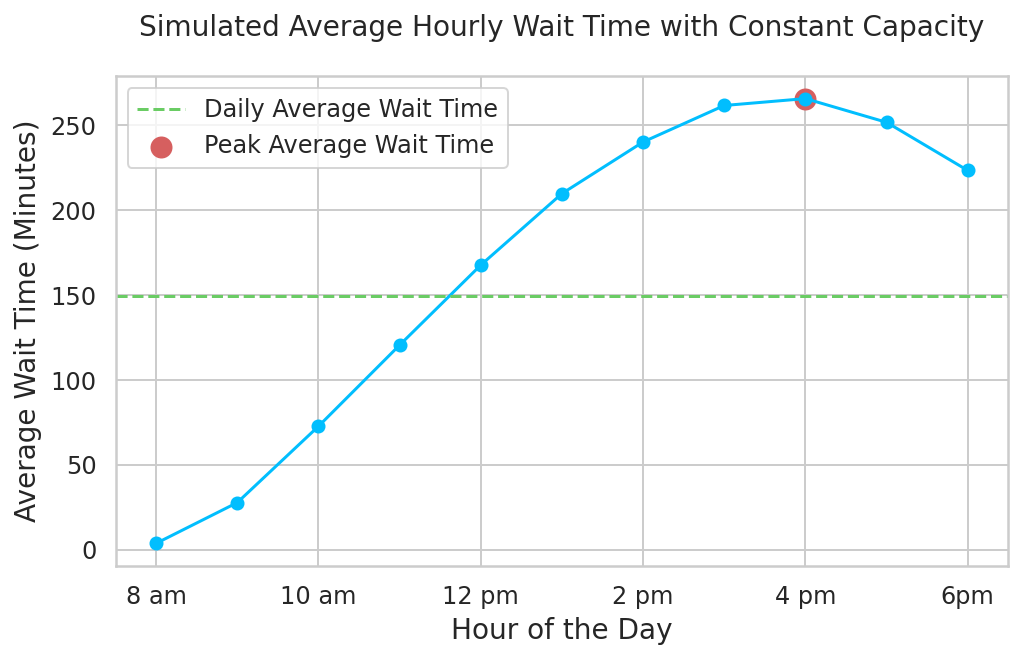

In [175]:
served, dropped = sim_waiting_time()
generate_plot(served, 'Simulated Average Hourly Wait Time with Constant Capacity')

In [178]:
np.mean(served['wait'])
testdf = served.groupby('hour')[['wait']].mean()
testdf['wait'].max()

265.66610085230116

In [1]:
10*60/4

150.0

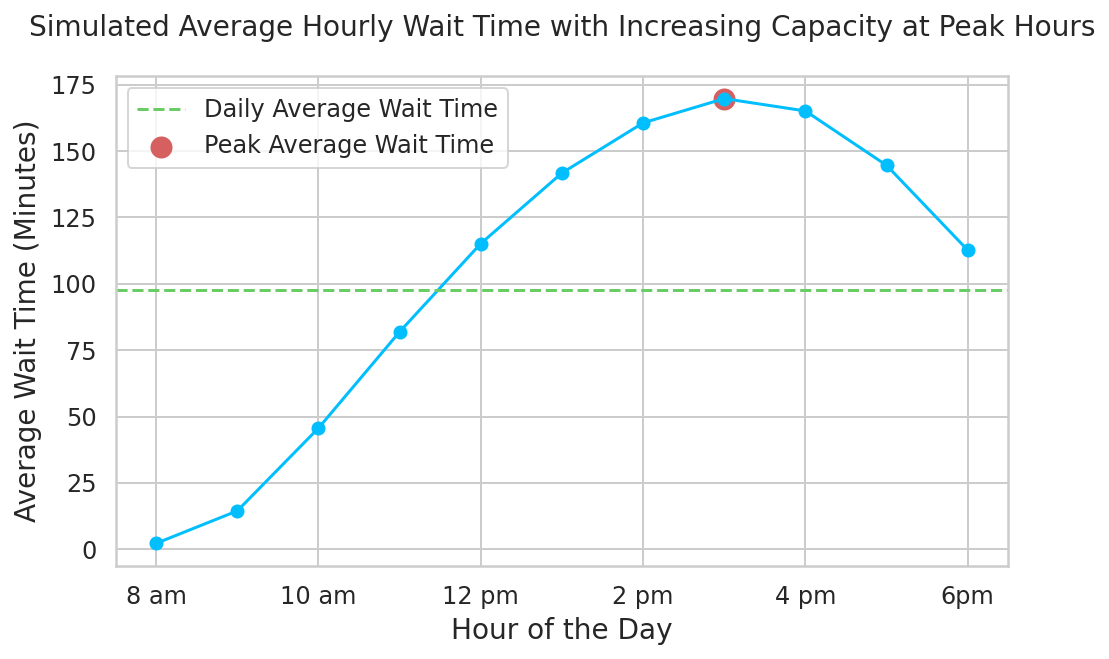

In [176]:
served1, dropped1 = sim_waiting_time(120, 140)
generate_plot(served1, 'Simulated Average Hourly Wait Time with Increasing Capacity at Peak Hours')